<a href="https://colab.research.google.com/github/Javed-ahmed-shanto/Deep-learning-for-developers/blob/main/ties4911_demo02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initial shape of data: (205, 26)
Initial columns: Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 45.16%


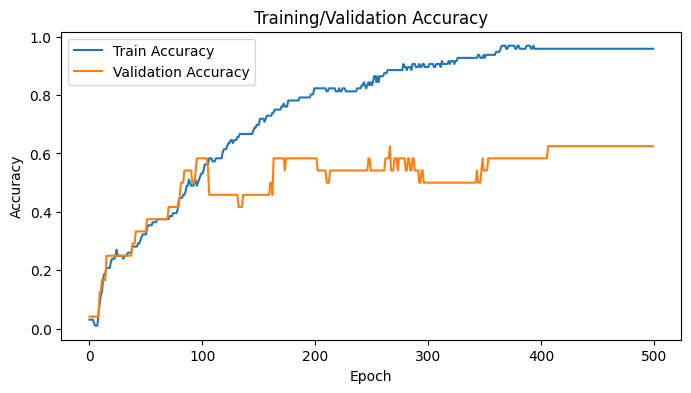

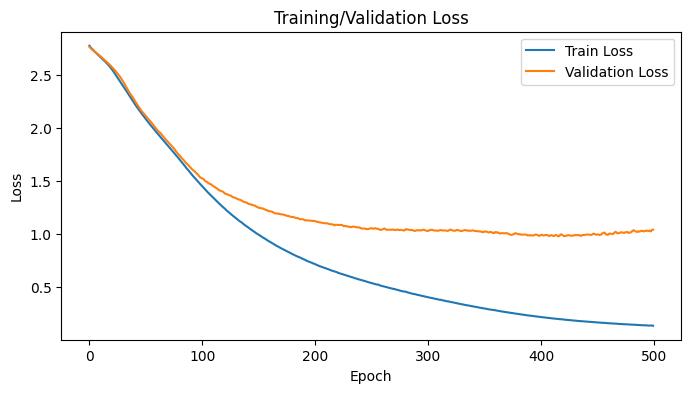

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

Predicted values for the two samples:
  Input: ['sedan', 103.5, 164, 121, 4250, 25, 24565] -> Predicted Make: bmw
  Input: ['hatchback', 86.6, 92, 58, 4800, 54, 6479] -> Predicted Make: chevrolet

Model Accuracy on Test Set: 45.16%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For one-hot encoding & label encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# TensorFlow Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Automobile_price_data_Raw_set.csv'
df = pd.read_csv(file_path)

print("Initial shape of data:", df.shape)
print("Initial columns:", df.columns)

# Replacing ±inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Dropping rows containing NaN
df.dropna(inplace=True)

# Convert numeric columns to proper numeric types
numeric_columns = ['wheel-base', 'engine-size', 'horsepower',
                   'peak-rpm', 'highway-mpg', 'price']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(subset=['make', 'body-style'] + numeric_columns, inplace=True)

# ----------------------------
# OPTIONAL: Remove rare classes
# ----------------------------
# This step ensures every class has at least 2 samples,
# so stratification won't fail.
min_class_count = 2
counts = df['make'].value_counts()
rare_classes = counts[counts < min_class_count].index
df = df[~df['make'].isin(rare_classes)]
# ----------------------------

# 3. SELECT FEATURES AND TARGET
X = df[['body-style', 'wheel-base', 'engine-size', 'horsepower',
        'peak-rpm', 'highway-mpg', 'price']]
y = df['make']

# 4. ENCODE CATEGORICAL COLUMNS & TARGET
ohe = OneHotEncoder(drop='first')
body_style_encoded = ohe.fit_transform(X[['body-style']]).toarray()

numeric_data = X[['wheel-base', 'engine-size', 'horsepower',
                  'peak-rpm', 'highway-mpg', 'price']].values

X_encoded = np.hstack((body_style_encoded, numeric_data))

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 5. SPLIT INTO TRAIN AND TEST

# Option A: WITHOUT stratify
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=0.2,
    random_state=42
)

# Option B: WITH stratify (only works if every class has >=2 samples)
# X_train, X_test, y_train, y_test = train_test_split(
#     X_encoded, y_encoded,
#     test_size=0.2,
#     random_state=42,
#     stratify=y_encoded
# )

scaler = StandardScaler()
num_start_idx = body_style_encoded.shape[1]
X_train[:, num_start_idx:] = scaler.fit_transform(X_train[:, num_start_idx:])
X_test[:, num_start_idx:] = scaler.transform(X_test[:, num_start_idx:])

# 6. BUILD THE NEURAL NETWORK MODEL
model = Sequential()from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Automobile_price_data_Raw_set.csv'
df = pd.read_csv(file_path)
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

# 7. COMPILE THE MODEL
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 8. TRAIN THE MODEL
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    verbose=0
)

# 9. EVALUATE THE MODEL
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# 10. PLOT TRAINING & VALIDATION RESULTS
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training/Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 11. MAKE PREDICTIONS ON NEW DATA
samples = [
    ['sedan', 103.5, 164, 121, 4250, 25, 24565],
    ['hatchback', 86.6, 92, 58, 4800, 54, 6479]
]

new_body_styles = [[s[0]] for s in samples]
new_numeric = np.array([s[1:] for s in samples], dtype=float)

new_body_styles_encoded = ohe.transform(new_body_styles).toarray()
new_numeric_scaled = scaler.transform(new_numeric)
X_new_encoded = np.hstack((new_body_styles_encoded, new_numeric_scaled))

predictions = model.predict(X_new_encoded)
predicted_classes = np.argmax(predictions, axis=1)
predicted_makes = label_encoder.inverse_transform(predicted_classes)

print("\nPredicted values for the two samples:")
for i, sample in enumerate(samples):
    print(f"  Input: {sample} -> Predicted Make: {predicted_makes[i]}")

print(f"\nModel Accuracy on Test Set: {test_accuracy*100:.2f}%")


Initial shape of data: (205, 26)
Initial columns: Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

Shape after selecting required columns: (205, 8)
Shape after handling missing values: (200, 8)
Shape after removing rare classes: (199, 8)

Before SMOTE, X_train shape: (159, 10)
After  SMOTE, X_train_res shape: (525, 10)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Test Accuracy: 27.50%


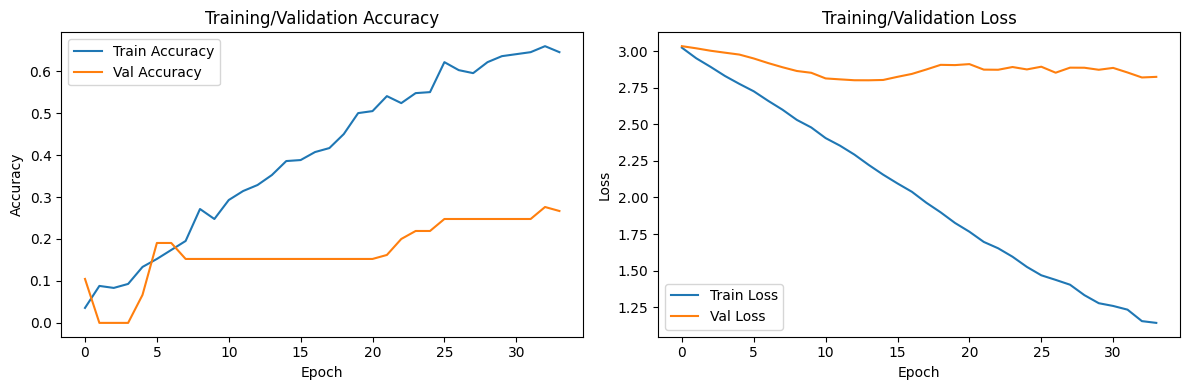

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step

Predicted values for the two samples:
  Input: ['sedan', 103.5, 164, 121, 4250, 25, 24565] -> Predicted Make: mercedes-benz
  Input: ['hatchback', 86.6, 92, 58, 4800, 54, 6479] -> Predicted Make: mazda

Final Model Accuracy on Test Set: 27.50%


In [ ]:
# If using Google Colab or a new environment, install imbalanced-learn:
# !pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For one-hot encoding & label encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# SMOTE for artificially increasing dataset size by oversampling
from imblearn.over_sampling import SMOTE

# TensorFlow Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# -----------------------------
# 1. LOAD THE DATA
# -----------------------------
url = "http://users.jyu.fi/~olkhriye/ties4911/demos/demo1/Automobile_price_data_Raw_set.csv"
df = pd.read_csv(url)

print("Initial shape of data:", df.shape)
print("Initial columns:", df.columns)

# -----------------------------
# 2. DATA CLEANING
# -----------------------------
# Replace "?" with np.nan so we can handle missing values properly
df.replace("?", np.nan, inplace=True)

# Numeric columns we need
numeric_columns = ['wheel-base', 'engine-size', 'horsepower',
                   'peak-rpm', 'highway-mpg', 'price']

# Convert these to numeric (coercing invalid to NaN)
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# We'll use these columns plus target 'make' and input 'body-style'.
required_columns = ['make', 'body-style'] + numeric_columns
df = df[required_columns]
print("\nShape after selecting required columns:", df.shape)

# Impute numeric columns with the median
imputer = SimpleImputer(strategy='median')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# Remove rows where 'make' or 'body-style' is missing
df.dropna(subset=['make', 'body-style'], inplace=True)
print("Shape after handling missing values:", df.shape)

# (Optional) Remove extremely rare classes in 'make' across the entire dataset
min_class_count = 2
counts = df['make'].value_counts()
rare_classes = counts[counts < min_class_count].index
df = df[~df['make'].isin(rare_classes)]
print("Shape after removing rare classes:", df.shape)

# -----------------------------
# 3. SELECT FEATURES & TARGET
# -----------------------------
X = df[['body-style', 'wheel-base', 'engine-size', 'horsepower',
        'peak-rpm', 'highway-mpg', 'price']]
y = df['make']

# -----------------------------
# 4. ENCODE CATEGORICAL & TARGET
# -----------------------------
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
body_style_encoded = ohe.fit_transform(X[['body-style']]).toarray()

numeric_data = X[numeric_columns].values

# Concatenate one-hot with numeric
X_encoded = np.hstack((body_style_encoded, numeric_data))

# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# -----------------------------
# 5. TRAIN/TEST SPLIT
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded  # maintain class ratio
)

# -----------------------------
# 6. ARTIFICIALLY INCREASE DATASET (SMOTE) ON TRAIN SET
# -----------------------------
# Set k_neighbors=1 to handle classes with only 2 samples
sm = SMOTE(random_state=42, k_neighbors=1)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("\nBefore SMOTE, X_train shape:", X_train.shape)
print("After  SMOTE, X_train_res shape:", X_train_res.shape)

# -----------------------------
# 7. SCALING
# -----------------------------
num_ohe_cols = body_style_encoded.shape[1]  # columns used by one-hot

scaler = StandardScaler()
X_train_res[:, num_ohe_cols:] = scaler.fit_transform(X_train_res[:, num_ohe_cols:])
X_test[:, num_ohe_cols:] = scaler.transform(X_test[:, num_ohe_cols:])

# -----------------------------
# 8. BUILD & COMPILE THE MODEL
# -----------------------------
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_res.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# -----------------------------
# 9. TRAIN THE MODEL
# -----------------------------
early_stop = EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')

history = model.fit(
    X_train_res,
    y_train_res,
    validation_split=0.2,
    epochs=1000,
    batch_size=64,
    verbose=0,
    callbacks=[early_stop]
)

# -----------------------------
# 10. EVALUATE THE MODEL
# -----------------------------
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

# -----------------------------
# 11. PLOT TRAINING & VALIDATION
# -----------------------------
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training/Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# -----------------------------
# 12. PREDICT ON NEW DATA
# -----------------------------
samples = [
    ['sedan', 103.5, 164, 121, 4250, 25, 24565],
    ['hatchback', 86.6, 92, 58, 4800, 54, 6479]
]

# Separate body-style and numeric columns
new_body_styles = [[s[0]] for s in samples]
new_numeric = np.array([s[1:] for s in samples], dtype=float)

# Encode
new_body_styles_encoded = ohe.transform(new_body_styles).toarray()
new_numeric_scaled = scaler.transform(new_numeric)

X_new_encoded = np.hstack((new_body_styles_encoded, new_numeric_scaled))

# Predict
predictions = model.predict(X_new_encoded)
predicted_classes = np.argmax(predictions, axis=1)
predicted_makes = label_encoder.inverse_transform(predicted_classes)

print("\nPredicted values for the two samples:")
for i, sample in enumerate(samples):
    print(f"  Input: {sample} -> Predicted Make: {predicted_makes[i]}")

print(f"\nFinal Model Accuracy on Test Set: {test_accuracy*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Accuracy: 51.35%


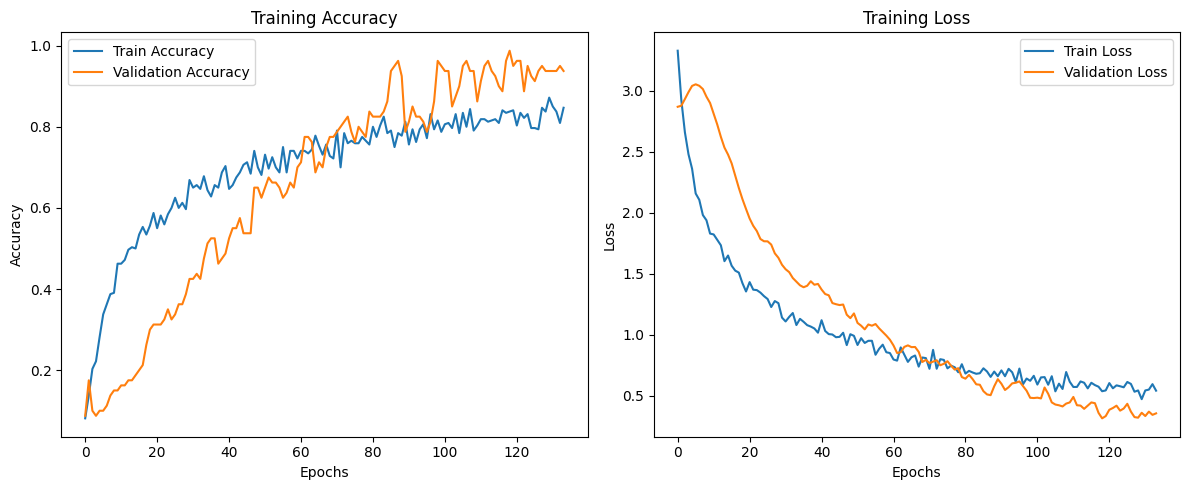

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step

Predictions:
Input: ['sedan', 103.5, 164, 121, 4250, 25, 24565] -> Predicted Make: bmw
Input: ['hatchback', 86.6, 92, 58, 4800, 54, 6479] -> Predicted Make: honda


In [ ]:
# Install required packages if needed
# !pip install imbalanced-learn tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# -----------------------------
# 1. LOAD AND CLEAN DATA
# -----------------------------
url = "http://users.jyu.fi/~olkhriye/ties4911/demos/demo1/Automobile_price_data_Raw_set.csv"
df = pd.read_csv(url)

# Clean and preprocess data
df.replace("?", np.nan, inplace=True)
numeric_columns = ['wheel-base', 'engine-size', 'horsepower', 'peak-rpm', 'highway-mpg', 'price']
required_columns = ['make', 'body-style'] + numeric_columns
df = df[required_columns]

# Convert to numeric and handle missing values
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute missing values
imputer = SimpleImputer(strategy='median')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
df.dropna(subset=['make', 'body-style'], inplace=True)

# Filter classes with minimum samples
min_class_count = 5  # Increased minimum samples per class
counts = df['make'].value_counts()
df = df[df['make'].isin(counts[counts >= min_class_count].index)]

# -----------------------------
# 2. PREPROCESSING
# -----------------------------
# Feature engineering: Add price per horsepower
df['price-per-hp'] = df['price'] / (df['horsepower'] + 1e-6)  # Avoid division by zero

# Encode categorical features
X = df[['body-style'] + numeric_columns + ['price-per-hp']]
y = df['make']

# Encode features and target
ohe = OneHotEncoder(drop='first', sparse_output=False)  # For scikit-learn >= 1.2
body_style_encoded = ohe.fit_transform(X[['body-style']])

# Combine features
numeric_features = X[numeric_columns + ['price-per-hp']].values
X_processed = np.hstack([body_style_encoded, numeric_features])

# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# -----------------------------
# 3. DATA SPLITTING AND SCALING
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

# Scale numeric features (excluding one-hot encoded columns)
num_ohe_cols = body_style_encoded.shape[1]
scaler = StandardScaler()
X_train[:, num_ohe_cols:] = scaler.fit_transform(X_train[:, num_ohe_cols:])
X_test[:, num_ohe_cols:] = scaler.transform(X_test[:, num_ohe_cols:])

# Apply SMOTE after scaling
sm = SMOTE(k_neighbors=3, random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# -----------------------------
# 4. MODEL ARCHITECTURE
# -----------------------------
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_res.shape[1],), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# 5. MODEL TRAINING
# -----------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    X_res, y_res,
    validation_split=0.2,
    epochs=1000,
    batch_size=16,
    verbose=0,
    callbacks=[early_stop]
)

# -----------------------------
# 6. EVALUATION AND PREDICTIONS
# -----------------------------
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Accuracy: {test_acc*100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Predict new samples
new_samples = [
    ['sedan', 103.5, 164, 121, 4250, 25, 24565],
    ['hatchback', 86.6, 92, 58, 4800, 54, 6479]
]

# Preprocess new samples
new_df = pd.DataFrame(new_samples, columns=['body-style'] + numeric_columns)
new_df['price-per-hp'] = new_df['price'] / (new_df['horsepower'] + 1e-6)

body_style_encoded_new = ohe.transform(new_df[['body-style']])
numeric_features_new = scaler.transform(new_df[numeric_columns + ['price-per-hp']])
X_new = np.hstack([body_style_encoded_new, numeric_features_new])

# Make predictions
predictions = model.predict(X_new)
predicted_classes = np.argmax(predictions, axis=1)
predicted_makes = label_encoder.inverse_transform(predicted_classes)

print("\nPredictions:")
for sample, make in zip(new_samples, predicted_makes):
    print(f"Input: {sample} -> Predicted Make: {make}")

Before SMOTE: (294, 8)
After SMOTE:  (784, 11)
Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.1004 - loss: 3.6795 - val_accuracy: 0.1720 - val_loss: 2.9511
Epoch 2/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3392 - loss: 2.4857 - val_accuracy: 0.1401 - val_loss: 2.9041
Epoch 3/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3880 - loss: 2.1419 - val_accuracy: 0.1911 - val_loss: 2.7955
Epoch 4/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4560 - loss: 1.9623 - val_accuracy: 0.1847 - val_loss: 2.7222
Epoch 5/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4930 - loss: 1.8908 - val_accuracy: 0.1975 - val_loss: 2.5759
Epoch 6/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5222 - loss: 1.7146 - val_accuracy: 0.2611 - val_loss: 2.3989
Epoch 7/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5357 - loss: 1.7154 - val_accuracy: 0.3057 - val_loss: 2.2586
Epoch 8/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5957 - loss: 1.4845 - val_accuracy: 0.3631 - val_loss: 2.

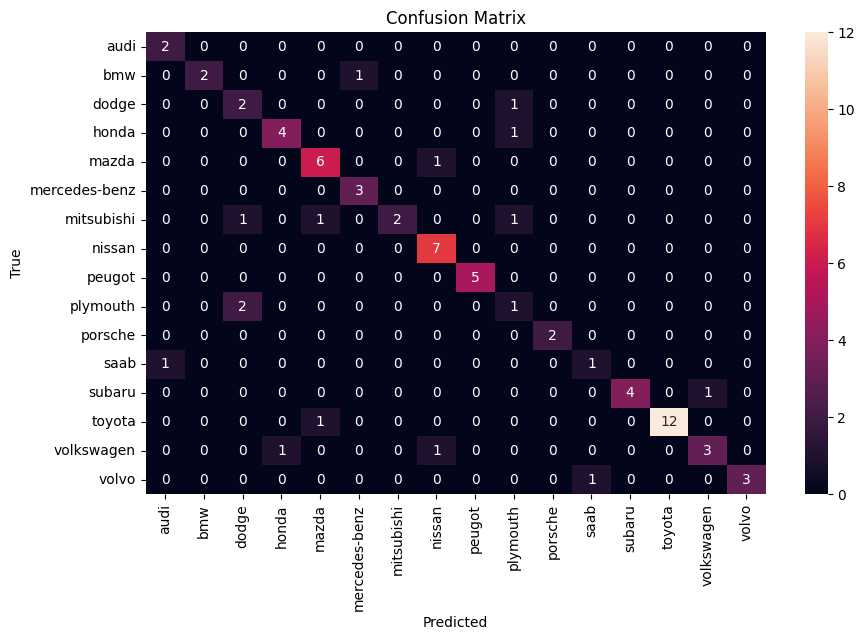

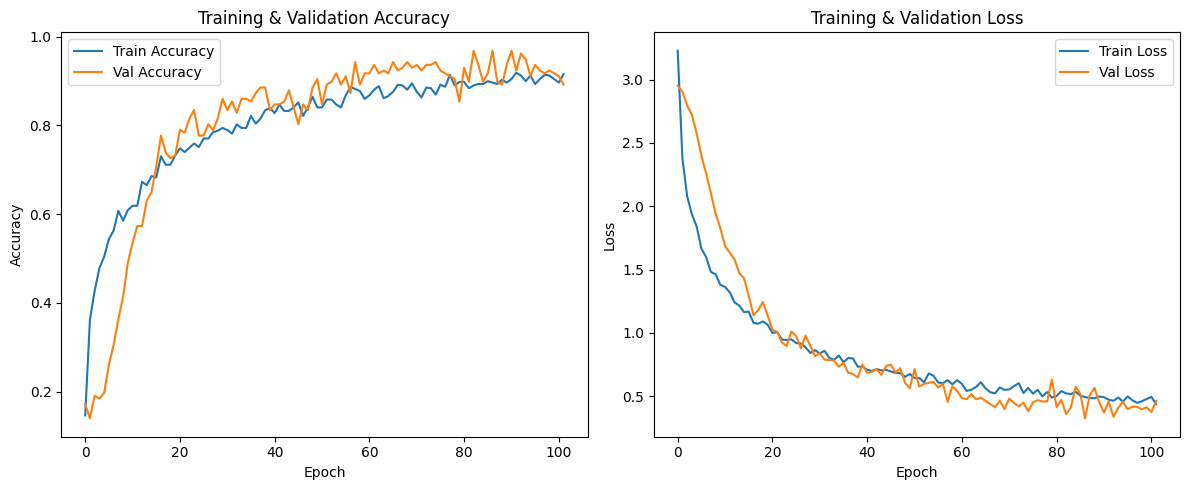

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step

Predictions on new samples:
Input: ['sedan', 103.5, 164, 121, 4250, 25, 24565] -> Predicted Make: bmw
Input: ['hatchback', 86.6, 92, 58, 4800, 54, 6479] -> Predicted Make: honda


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

# NOTE: We import Pipeline from imblearn, not sklearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# ---------------------------------------------------------------------
# 0. SET RANDOM SEEDS (for reproducibility)
# ---------------------------------------------------------------------
np.random.seed(42)
tf.random.set_seed(42)

# ---------------------------------------------------------------------
# 1. CUSTOM DATA AUGMENTATION (OPTIONAL)
# ---------------------------------------------------------------------
def augment_numeric_data(df, numeric_cols, n_copies=1, noise_std=0.01):
    """
    Create synthetic duplicates of existing rows by adding small random noise
    to numeric columns. This is a simplistic method and should be tuned/validated
    for real-world use.

    Parameters:
    -----------
    df : pd.DataFrame
        Original dataframe
    numeric_cols : list
        List of numeric column names
    n_copies : int
        Number of synthetic copies (per original row) to create
    noise_std : float
        Standard deviation of the Gaussian noise to add

    Returns:
    --------
    df_aug : pd.DataFrame
        Augmented dataframe (original + synthetic)
    """
    df_numeric = df[numeric_cols]
    df_others = df.drop(columns=numeric_cols)

    augmented_rows = []
    for _ in range(n_copies):
        noise = np.random.normal(loc=0.0, scale=noise_std, size=df_numeric.shape)
        # Add relative noise: new_value = old_value + noise * old_value
        df_numeric_aug = df_numeric + noise * df_numeric
        df_aug_piece = pd.concat(
            [df_others.reset_index(drop=True), df_numeric_aug.reset_index(drop=True)],
            axis=1
        )
        augmented_rows.append(df_aug_piece)

    df_aug = pd.concat([df] + augmented_rows, ignore_index=True)
    return df_aug

# ---------------------------------------------------------------------
# 2. LOAD AND INITIAL CLEANING
# ---------------------------------------------------------------------
url = "http://users.jyu.fi/~olkhriye/ties4911/demos/demo1/Automobile_price_data_Raw_set.csv"
df = pd.read_csv(url)

df.replace("?", np.nan, inplace=True)

numeric_columns = ['wheel-base', 'engine-size', 'horsepower',
                   'peak-rpm', 'highway-mpg', 'price']
required_columns = ['make', 'body-style'] + numeric_columns
df = df[required_columns].copy()

# Convert to numeric
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute numeric columns with median
imputer = SimpleImputer(strategy='median')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# Drop rows with missing target or major categorical columns
df.dropna(subset=['make', 'body-style'], inplace=True)

# Filter out classes with very few samples
min_class_count = 5
counts = df['make'].value_counts()
df = df[df['make'].isin(counts[counts >= min_class_count].index)].copy()

# Feature engineering: Add price per horsepower
df['price-per-hp'] = df['price'] / (df['horsepower'] + 1e-6)

# ---------------------------------------------------------------------
# 3. DATA AUGMENTATION (OPTIONAL)
# ---------------------------------------------------------------------
# Example: create 1 synthetic copy for each row with ~2% noise
# If your dataset is already large enough, you can skip this step.
df_aug = augment_numeric_data(
    df,
    numeric_cols=numeric_columns + ['price-per-hp'],
    n_copies=1,
    noise_std=0.02
)

df_aug.reset_index(drop=True, inplace=True)

# ---------------------------------------------------------------------
# 4. SEPARATE FEATURES & TARGET
# ---------------------------------------------------------------------
cat_features = ['body-style']
num_features = numeric_columns + ['price-per-hp']

X = df_aug[cat_features + num_features]
y = df_aug['make']

# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# ---------------------------------------------------------------------
# 5. TRAIN-TEST SPLIT
# ---------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

# ---------------------------------------------------------------------
# 6. PREPROCESSOR & SMOTE PIPELINE
# ---------------------------------------------------------------------
# We'll one-hot encode body-style, scale numeric features, then apply SMOTE.

preprocessor = ColumnTransformer(
    transformers=[
        # OneHotEncoder for categorical, StandardScaler for numeric
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
        ('num', StandardScaler(), num_features)
    ]
)

pipeline_steps = [
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=3, random_state=42))
]

# IMPORTANT: Use imblearn's Pipeline to allow fit_resample
oversample_pipeline = Pipeline(steps=pipeline_steps)

# Fit and resample ONLY on the training set
X_train_resampled, y_train_resampled = oversample_pipeline.fit_resample(X_train, y_train)
print("Before SMOTE:", X_train.shape)
print("After SMOTE: ", X_train_resampled.shape)

# We will transform the test set *without* SMOTE
# (No oversampling on test data to avoid data leakage)
X_test_preprocessed = oversample_pipeline.named_steps['preprocessor'].transform(X_test)

# ---------------------------------------------------------------------
# 7. BUILD & COMPILE THE MODEL
# ---------------------------------------------------------------------
input_dim = X_train_resampled.shape[1]

model = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ---------------------------------------------------------------------
# 8. TRAIN THE MODEL
# ---------------------------------------------------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_split=0.2,
    epochs=300,
    batch_size=16,
    verbose=1,
    callbacks=[early_stop]
)

# ---------------------------------------------------------------------
# 9. EVALUATE MODEL
# ---------------------------------------------------------------------
test_loss, test_acc = model.evaluate(X_test_preprocessed, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

# Generate predictions
y_pred_probs = model.predict(X_test_preprocessed)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_names = label_encoder.classes_
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 10. PREDICT ON NEW SAMPLES
# ---------------------------------------------------------------------
new_samples = [
    ['sedan', 103.5, 164, 121, 4250, 25, 24565],
    ['hatchback', 86.6, 92, 58, 4800, 54, 6479]
]

new_df = pd.DataFrame(new_samples, columns=['body-style'] + numeric_columns)
new_df['price-per-hp'] = new_df['price'] / (new_df['horsepower'] + 1e-6)

# Preprocess (no SMOTE) - just transform with the same preprocessor
new_preprocessed = oversample_pipeline.named_steps['preprocessor'].transform(new_df)

# Predict
predictions = model.predict(new_preprocessed)
predicted_classes = np.argmax(predictions, axis=1)
predicted_makes = label_encoder.inverse_transform(predicted_classes)

print("\nPredictions on new samples:")
for sample, make in zip(new_samples, predicted_makes):
    print(f"Input: {sample} -> Predicted Make: {make}")


Before SMOTE: (294, 8)
After SMOTE:  (784, 11)
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.0688 - loss: 3.2235

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.0694 - loss: 3.2209 - val_accuracy: 0.0637 - val_loss: 2.8192
Epoch 2/200
20/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1756 - loss: 2.7970 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1695 - loss: 2.7868 - val_accuracy: 0.1911 - val_loss: 2.8029
Epoch 3/200
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1888 - loss: 2.6892 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2072 - loss: 2.6245 - val_accuracy: 0.2038 - val_loss: 2.7497
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2333 - loss: 2.4583 - val_accuracy: 0.1975 - val_loss: 2.7255
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2963 - loss: 2.3117 - val_accuracy: 0.1911 - val_loss: 2.6717
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2874 - loss: 2.2768 - val_accuracy: 0.1847 - val_loss: 2.6357
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3789 - loss: 2.1310 - val_accuracy: 0.2038 - val_loss: 2.5750
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3428 - loss: 2.1266 - val_accuracy: 0.2038 - val_loss: 2.5341
Epoch 9/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3548 - loss: 2.0470 - val_accuracy: 0.2038 - val_loss: 2.5035
Epoch 10/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3824 - loss: 2.0623 - val_accuracy: 0.1975 - val_loss: 2.

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4663 - loss: 1.7411 - val_accuracy: 0.2357 - val_loss: 2.2444
Epoch 21/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4649 - loss: 1.6668 - val_accuracy: 0.2229 - val_loss: 2.1912
Epoch 22/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4774 - loss: 1.6870 - val_accuracy: 0.2229 - val_loss: 2.1560
Epoch 23/200
23/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4754 - loss: 1.6753 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4805 - loss: 1.6467 - val_accuracy: 0.2420 - val_loss: 2.1604
Epoch 24/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4995 - loss: 1.6754 - val_accuracy: 0.1975 - val_loss: 2.1213
Epoch 25/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4620 - loss: 1.6529 - val_accuracy: 0.2229 - val_loss: 2.0875
Epoch 26/200
23/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5011 - loss: 1.6854 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5082 - loss: 1.6376 - val_accuracy: 0.2548 - val_loss: 2.0159
Epoch 27/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4890 - loss: 1.6529 - val_accuracy: 0.2293 - val_loss: 2.0353
Epoch 28/200
23/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5035 - loss: 1.6379 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5125 - loss: 1.6018 - val_accuracy: 0.2675 - val_loss: 1.9673
Epoch 29/200
23/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5125 - loss: 1.6008 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5087 - loss: 1.5704 - val_accuracy: 0.2994 - val_loss: 1.9476
Epoch 30/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5439 - loss: 1.5053 - val_accuracy: 0.2866 - val_loss: 1.8975
Epoch 31/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5227 - loss: 1.4842 - val_accuracy: 0.2866 - val_loss: 1.8609
Epoch 32/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4990 - loss: 1.4925 - val_accuracy: 0.2994 - val_loss: 1.8422
Epoch 33/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5356 - loss: 1.4369 - val_accuracy: 0.2994 - val_loss: 1.7880
Epoch 34/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5156 - loss: 1.5447 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5301 - loss: 1.4975 - val_accuracy: 0.3121 - val_loss: 1.8116
Epoch 35/200
23/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4898 - loss: 1.5092 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5066 - loss: 1.4823 - val_accuracy: 0.3248 - val_loss: 1.7455
Epoch 36/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5078 - loss: 1.5306 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5141 - loss: 1.4985 - val_accuracy: 0.3631 - val_loss: 1.7334
Epoch 37/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5658 - loss: 1.4116 - val_accuracy: 0.3312 - val_loss: 1.7441
Epoch 38/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5397 - loss: 1.4850 - val_accuracy: 0.3376 - val_loss: 1.6975
Epoch 39/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4925 - loss: 1.4737 - val_accuracy: 0.3503 - val_loss: 1.6740
Epoch 40/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5667 - loss: 1.3936 - val_accuracy: 0.3631 - val_loss: 1.6618
Epoch 41/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5178 - loss: 1.4617 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5353 - loss: 1.4134 - val_accuracy: 0.3694 - val_loss: 1.6568
Epoch 42/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5689 - loss: 1.3923 - val_accuracy: 0.3376 - val_loss: 1.6644
Epoch 43/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5285 - loss: 1.4345 - val_accuracy: 0.3567 - val_loss: 1.6474
Epoch 44/200
23/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5736 - loss: 1.3888 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5726 - loss: 1.3540 - val_accuracy: 0.4013 - val_loss: 1.6171
Epoch 45/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6173 - loss: 1.2988 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6138 - loss: 1.2910 - val_accuracy: 0.4204 - val_loss: 1.5600
Epoch 46/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5919 - loss: 1.2721 - val_accuracy: 0.4013 - val_loss: 1.5571
Epoch 47/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5974 - loss: 1.3451 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6094 - loss: 1.3026 - val_accuracy: 0.4522 - val_loss: 1.5020
Epoch 48/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5781 - loss: 1.3004 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5875 - loss: 1.2809 - val_accuracy: 0.4586 - val_loss: 1.5117
Epoch 49/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5749 - loss: 1.2826 - val_accuracy: 0.4076 - val_loss: 1.5154
Epoch 50/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6082 - loss: 1.3168 - val_accuracy: 0.4013 - val_loss: 1.5180
Epoch 51/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6082 - loss: 1.2127 - val_accuracy: 0.4204 - val_loss: 1.5348
Epoch 52/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5852 - loss: 1.2293 - val_accuracy: 0.4268 - val_loss: 1.4884
Epoch 53/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5737 - loss: 1.3114 - val_accuracy: 0.4331 - val_loss: 1.4454
Epoch 54/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6127 - loss: 1.2297 - val_accuracy: 0.4013 - val_loss: 1.4501
Epoch 55/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5930 - loss: 1.2450 - val_accuracy: 0.4331 - val_lo

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5591 - loss: 1.2861 - val_accuracy: 0.4968 - val_loss: 1.3776
Epoch 58/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6440 - loss: 1.2071 - val_accuracy: 0.4968 - val_loss: 1.3482
Epoch 59/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5789 - loss: 1.2901 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5917 - loss: 1.2521 - val_accuracy: 0.5478 - val_loss: 1.3367
Epoch 60/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6032 - loss: 1.2676 - val_accuracy: 0.5159 - val_loss: 1.3738
Epoch 61/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6189 - loss: 1.2018 - val_accuracy: 0.5478 - val_loss: 1.4167
Epoch 62/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6200 - loss: 1.2157 - val_accuracy: 0.5032 - val_loss: 1.3871
Epoch 63/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5979 - loss: 1.2062 - val_accuracy: 0.5223 - val_loss: 1.3598
Epoch 64/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5833 - loss: 1.2261 - val_accuracy: 0.5159 - val_loss: 1.3295
Epoch 65/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6351 - loss: 1.1366 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6355 - loss: 1.1297 - val_accuracy: 0.5732 - val_loss: 1.2556
Epoch 66/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5932 - loss: 1.2626 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6116 - loss: 1.2254 - val_accuracy: 0.5860 - val_loss: 1.2654
Epoch 67/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5990 - loss: 1.2353 - val_accuracy: 0.5414 - val_loss: 1.2631
Epoch 68/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6419 - loss: 1.1263 - val_accuracy: 0.5732 - val_loss: 1.2461
Epoch 69/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6373 - loss: 1.1734 - val_accuracy: 0.5669 - val_loss: 1.2638
Epoch 70/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 1.1583 - val_accuracy: 0.5796 - val_loss: 1.2487
Epoch 71/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5942 - loss: 1.2016 - val_accuracy: 0.5669 - val_loss: 1.2378
Epoch 72/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6275 - loss: 1.1317 - val_accuracy: 0.5860 - val_loss: 1.2306
Epoch 73/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6252 - loss: 1.0990 - val_accuracy: 0.5541 - val_lo

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6427 - loss: 1.0937 - val_accuracy: 0.5924 - val_loss: 1.2196
Epoch 77/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6606 - loss: 1.0604 - val_accuracy: 0.5924 - val_loss: 1.2240
Epoch 78/200
23/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6102 - loss: 1.1526 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6134 - loss: 1.1397 - val_accuracy: 0.6051 - val_loss: 1.2237
Epoch 79/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6466 - loss: 1.1003 - val_accuracy: 0.5796 - val_loss: 1.2142
Epoch 80/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5942 - loss: 1.2051 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6119 - loss: 1.1588 - val_accuracy: 0.6115 - val_loss: 1.1800
Epoch 81/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6472 - loss: 1.0241 - val_accuracy: 0.6115 - val_loss: 1.1773
Epoch 82/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6693 - loss: 1.0579 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6699 - loss: 1.0338 - val_accuracy: 0.6178 - val_loss: 1.1325
Epoch 83/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6514 - loss: 1.0869 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6424 - loss: 1.0857 - val_accuracy: 0.6306 - val_loss: 1.1321
Epoch 84/200
23/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6120 - loss: 1.1209 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6238 - loss: 1.1069 - val_accuracy: 0.6433 - val_loss: 1.1230
Epoch 85/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6663 - loss: 1.0097 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6590 - loss: 1.0198 - val_accuracy: 0.6497 - val_loss: 1.0959
Epoch 86/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6669 - loss: 0.9792 - val_accuracy: 0.6433 - val_loss: 1.0805
Epoch 87/200
23/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6447 - loss: 1.0891 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6563 - loss: 1.0610 - val_accuracy: 0.6561 - val_loss: 1.0659
Epoch 88/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6984 - loss: 1.0147 - val_accuracy: 0.6433 - val_loss: 1.0755
Epoch 89/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6625 - loss: 1.0399 - val_accuracy: 0.6433 - val_loss: 1.0458
Epoch 90/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6842 - loss: 0.9777 - val_accuracy: 0.6242 - val_loss: 1.0767
Epoch 91/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6571 - loss: 1.0282 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6604 - loss: 1.0160 - val_accuracy: 0.6752 - val_loss: 1.0150
Epoch 92/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6845 - loss: 1.0316 - val_accuracy: 0.6688 - val_loss: 1.0063
Epoch 93/200
23/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7059 - loss: 1.0620 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6962 - loss: 1.0443 - val_accuracy: 0.7134 - val_loss: 0.9531
Epoch 94/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6762 - loss: 0.9846 - val_accuracy: 0.6815 - val_loss: 0.9640
Epoch 95/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6654 - loss: 1.0297 - val_accuracy: 0.7070 - val_loss: 0.9701
Epoch 96/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6401 - loss: 1.0699 - val_accuracy: 0.7070 - val_loss: 0.9813
Epoch 97/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6717 - loss: 1.0185 - val_accuracy: 0.7134 - val_loss: 0.9880
Epoch 98/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6819 - loss: 0.9876 - val_accuracy: 0.7134 - val_loss: 0.9748
Epoch 99/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7149 - loss: 1.0149 - val_accuracy: 0.7006 - val_loss: 0.9745
Epoch 100/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6808 - loss: 0.9682 - val_accuracy: 0.7070 - val_l

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6888 - loss: 0.9482 - val_accuracy: 0.7389 - val_loss: 0.9472
Epoch 102/200
23/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6626 - loss: 1.0330 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6604 - loss: 1.0222 - val_accuracy: 0.7452 - val_loss: 0.8866
Epoch 103/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6666 - loss: 1.0097 - val_accuracy: 0.7389 - val_loss: 0.9071
Epoch 104/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6464 - loss: 1.0486 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6511 - loss: 1.0329 - val_accuracy: 0.7580 - val_loss: 0.9399
Epoch 105/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6515 - loss: 1.0314 - val_accuracy: 0.6752 - val_loss: 0.9848
Epoch 106/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6788 - loss: 1.0484 - val_accuracy: 0.7134 - val_loss: 0.9934
Epoch 107/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6970 - loss: 1.0031 - val_accuracy: 0.6943 - val_loss: 0.9735
Epoch 108/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6701 - loss: 1.0298 - val_accuracy: 0.7134 - val_loss: 0.9353
Epoch 109/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6798 - loss: 0.9303 - val_accuracy: 0.7134 - val_loss: 0.9328
Epoch 110/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6465 - loss: 0.9673 - val_accuracy: 0.7516 - val_loss: 0.8961
Epoch 111/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6758 - loss: 1.0310 - val_accuracy: 0.7452 -

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7284 - loss: 0.9057 - val_accuracy: 0.7707 - val_loss: 0.8873
Epoch 114/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7221 - loss: 0.8925 - val_accuracy: 0.7516 - val_loss: 0.8710
Epoch 115/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7093 - loss: 0.8764 - val_accuracy: 0.7197 - val_loss: 0.8852
Epoch 116/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6895 - loss: 0.9097 - val_accuracy: 0.7325 - val_loss: 0.8683
Epoch 117/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6979 - loss: 0.9735 - val_accuracy: 0.6688 - val_loss: 0.9078
Epoch 118/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6745 - loss: 0.9555 - val_accuracy: 0.7452 - val_loss: 0.8570
Epoch 119/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7218 - loss: 0.9141 - val_accuracy: 0.7389 - val_loss: 0.8797
Epoch 120/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6776 - loss: 0.9594 - val_accuracy: 0.7389 -

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6914 - loss: 0.9018 - val_accuracy: 0.7771 - val_loss: 0.8598
Epoch 122/200
21/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7338 - loss: 0.8828 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7173 - loss: 0.8906 - val_accuracy: 0.7834 - val_loss: 0.8382
Epoch 123/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6791 - loss: 0.9857 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6864 - loss: 0.9470 - val_accuracy: 0.7962 - val_loss: 0.7968
Epoch 124/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7137 - loss: 0.8912 - val_accuracy: 0.7643 - val_loss: 0.8769
Epoch 125/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7245 - loss: 0.8685 - val_accuracy: 0.7134 - val_loss: 0.8908
Epoch 126/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7006 - loss: 0.8802 - val_accuracy: 0.7134 - val_loss: 0.8989
Epoch 127/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6789 - loss: 0.9164 - val_accuracy: 0.7643 - val_loss: 0.8476
Epoch 128/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7136 - loss: 0.8955 - val_accuracy: 0.7643 - val_loss: 0.8147
Epoch 129/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7833 - loss: 0.7245 - val_accuracy: 0.7325 - val_loss: 0.8340
Epoch 130/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6813 - loss: 0.9340 - val_accuracy: 0.7771 -

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6771 - loss: 0.9210 - val_accuracy: 0.8089 - val_loss: 0.7610
Epoch 133/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7054 - loss: 0.8926 - val_accuracy: 0.7898 - val_loss: 0.7839
Epoch 134/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7362 - loss: 0.8716 - val_accuracy: 0.7261 - val_loss: 0.8474
Epoch 135/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6992 - loss: 0.9054 - val_accuracy: 0.7325 - val_loss: 0.8602
Epoch 136/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7153 - loss: 0.9214 - val_accuracy: 0.7452 - val_loss: 0.8054
Epoch 137/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6936 - loss: 0.8737 - val_accuracy: 0.7006 - val_loss: 0.8749
Epoch 138/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7241 - loss: 0.8445 - val_accuracy: 0.7006 - val_loss: 0.8347
Epoch 139/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6916 - loss: 0.9319 - val_accuracy: 0.7707 -

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7220 - loss: 0.8606 - val_accuracy: 0.8217 - val_loss: 0.7171
Epoch 148/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7606 - loss: 0.8080 - val_accuracy: 0.8025 - val_loss: 0.7388
Epoch 149/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7425 - loss: 0.8309 - val_accuracy: 0.8217 - val_loss: 0.7021
Epoch 150/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7456 - loss: 0.8069 - val_accuracy: 0.8153 - val_loss: 0.6880
Epoch 151/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7272 - loss: 0.8582 - val_accuracy: 0.7962 - val_loss: 0.7035
Epoch 152/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7385 - loss: 0.7585 - val_accuracy: 0.7452 - val_loss: 0.7292
Epoch 153/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6826 - loss: 0.8666 - val_accuracy: 0.7771 - val_loss: 0.7147
Epoch 154/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7038 - loss: 0.8528 - val_accuracy: 0.7643 -

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7290 - loss: 0.8209 - val_accuracy: 0.8344 - val_loss: 0.6422
Epoch 158/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7590 - loss: 0.7951 - val_accuracy: 0.8280 - val_loss: 0.6167
Epoch 159/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7144 - loss: 0.8341 - val_accuracy: 0.8280 - val_loss: 0.5840
Epoch 160/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7374 - loss: 0.8443 - val_accuracy: 0.7834 - val_loss: 0.6336
Epoch 161/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7701 - loss: 0.7396 - val_accuracy: 0.8089 - val_loss: 0.6340
Epoch 162/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7134 - loss: 0.8415 - val_accuracy: 0.8217 - val_loss: 0.6492
Epoch 163/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7182 - loss: 0.8602 - val_accuracy: 0.7771 - val_loss: 0.6989
Epoch 164/200
22/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7509 - loss: 0.8146 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7473 - loss: 0.8233 - val_accuracy: 0.8408 - val_loss: 0.6321
Epoch 165/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7529 - loss: 0.7741 - val_accuracy: 0.8280 - val_loss: 0.6252
Epoch 166/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7570 - loss: 0.7296 - val_accuracy: 0.8280 - val_loss: 0.6121
Epoch 167/200
20/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7328 - loss: 0.7990 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7347 - loss: 0.7984 - val_accuracy: 0.8471 - val_loss: 0.6355
Epoch 168/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7567 - loss: 0.7745 - val_accuracy: 0.8153 - val_loss: 0.6507
Epoch 169/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7543 - loss: 0.8038 - val_accuracy: 0.7771 - val_loss: 0.6922
Epoch 170/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7431 - loss: 0.8248 - val_accuracy: 0.7962 - val_loss: 0.6857
Epoch 171/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7108 - loss: 0.8210 - val_accuracy: 0.8153 - val_loss: 0.6395
Epoch 172/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7364 - loss: 0.7965 - val_accuracy: 0.8089 - val_loss: 0.6329
Epoch 173/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7426 - loss: 0.7323 - val_accuracy: 0.7898 - val_loss: 0.6156
Epoch 174/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7051 - loss: 0.8348 - val_accuracy: 0.8217 -

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7426 - loss: 0.8161 - val_accuracy: 0.8535 - val_loss: 0.5974
Epoch 179/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7904 - loss: 0.7019 - val_accuracy: 0.8280 - val_loss: 0.5934

Test Accuracy: 77.03%
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step

Classification Report:
               precision    recall  f1-score   support

         audi       0.50      1.00      0.67         2
          bmw       1.00      1.00      1.00         3
        dodge       0.40      0.67      0.50         3
        honda       1.00      0.80      0.89         5
        mazda       0.83      0.71      0.77         7
mercedes-benz       1.00      1.00      1.00         3
   mitsubishi       0.67      0.80      0.73         5
       nissan       0.70      1.00      0.82         7
       peugot       1.00      1.00      1.00         5
     plymouth       0.33      0.33      0.33         3
      porsche       1.00      1.00      1.00         2
         

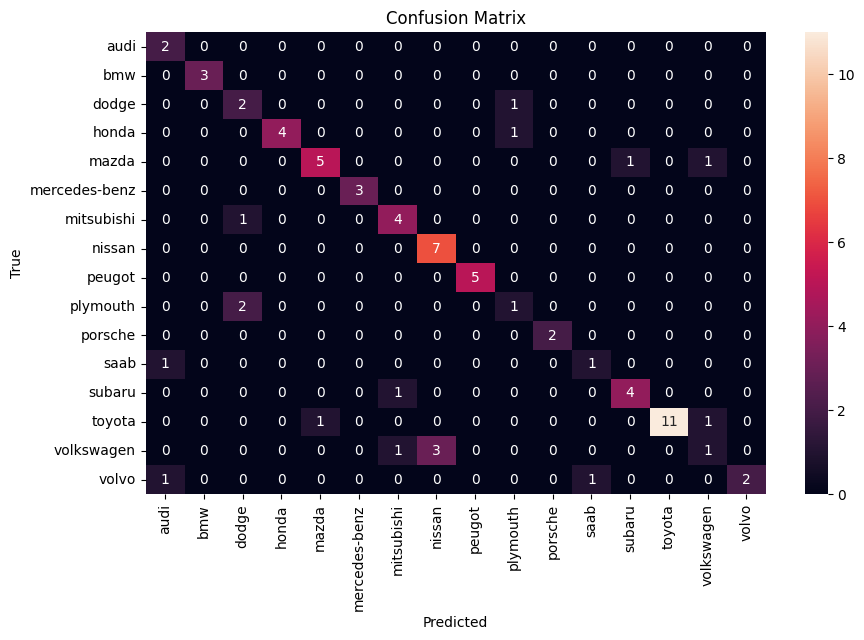

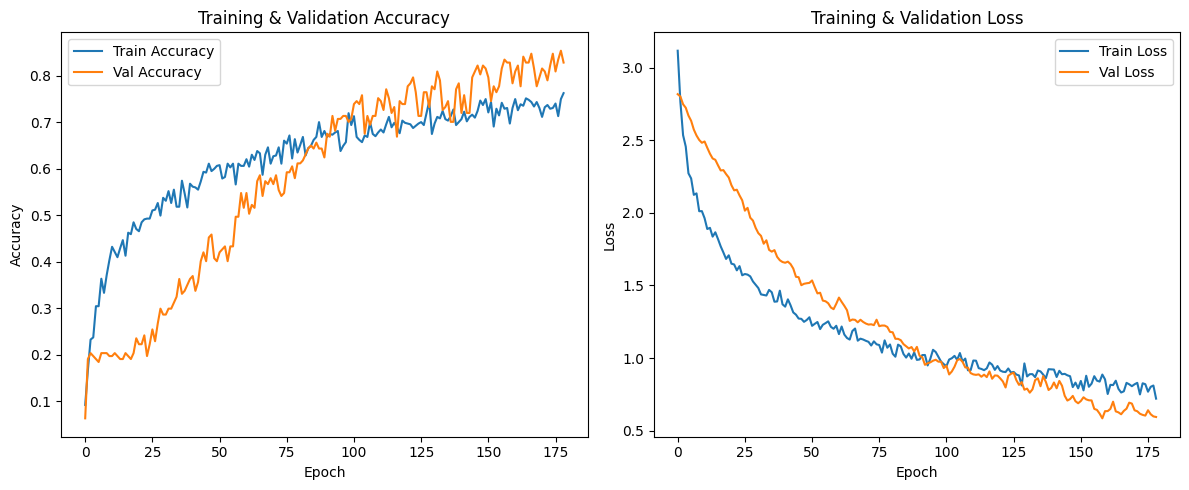

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step

Predictions on new samples:
Input: ['sedan', 103.5, 164, 121, 4250, 25, 24565] -> Predicted Make: bmw
Input: ['hatchback', 86.6, 92, 58, 4800, 54, 6479] -> Predicted Make: honda


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

# Import Pipeline from imblearn to allow fit_resample
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# ---------------------------------------------------------------------
# 0. SET RANDOM SEEDS (for reproducibility)
# ---------------------------------------------------------------------
np.random.seed(42)
tf.random.set_seed(42)

# ---------------------------------------------------------------------
# 1. CUSTOM DATA AUGMENTATION (OPTIONAL)
# ---------------------------------------------------------------------
def augment_numeric_data(df, numeric_cols, n_copies=1, noise_std=0.01):
    """
    Create synthetic duplicates of existing rows by adding small random noise
    to numeric columns. This is a simplistic method and should be tuned/validated
    for real-world use.

    Parameters:
    -----------
    df : pd.DataFrame
        Original dataframe
    numeric_cols : list
        List of numeric column names
    n_copies : int
        Number of synthetic copies (per original row) to create
    noise_std : float
        Standard deviation of the Gaussian noise to add

    Returns:
    --------
    df_aug : pd.DataFrame
        Augmented dataframe (original + synthetic)
    """
    df_numeric = df[numeric_cols]
    df_others = df.drop(columns=numeric_cols)

    augmented_rows = []
    for _ in range(n_copies):
        noise = np.random.normal(loc=0.0, scale=noise_std, size=df_numeric.shape)
        # Add relative noise: new_value = old_value + noise * old_value
        df_numeric_aug = df_numeric + noise * df_numeric
        df_aug_piece = pd.concat(
            [df_others.reset_index(drop=True), df_numeric_aug.reset_index(drop=True)],
            axis=1
        )
        augmented_rows.append(df_aug_piece)

    df_aug = pd.concat([df] + augmented_rows, ignore_index=True)
    return df_aug

# ---------------------------------------------------------------------
# 2. LOAD AND INITIAL CLEANING
# ---------------------------------------------------------------------
url = "http://users.jyu.fi/~olkhriye/ties4911/demos/demo1/Automobile_price_data_Raw_set.csv"
df = pd.read_csv(url)

df.replace("?", np.nan, inplace=True)

numeric_columns = ['wheel-base', 'engine-size', 'horsepower',
                   'peak-rpm', 'highway-mpg', 'price']
required_columns = ['make', 'body-style'] + numeric_columns
df = df[required_columns].copy()

# Convert to numeric
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute numeric columns with median
imputer = SimpleImputer(strategy='median')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# Drop rows with missing target or major categorical columns
df.dropna(subset=['make', 'body-style'], inplace=True)

# Filter out classes with very few samples
min_class_count = 5
counts = df['make'].value_counts()
df = df[df['make'].isin(counts[counts >= min_class_count].index)].copy()

# Feature engineering: Add price per horsepower
df['price-per-hp'] = df['price'] / (df['horsepower'] + 1e-6)

# ---------------------------------------------------------------------
# 3. DATA AUGMENTATION (OPTIONAL)
# ---------------------------------------------------------------------
# For demonstration, we create 1 synthetic copy, but lower noise to 0.005
# to reduce the potential for unrealistic training data.
df_aug = augment_numeric_data(
    df,
    numeric_cols=numeric_columns + ['price-per-hp'],
    n_copies=1,
    noise_std=0.005
)

df_aug.reset_index(drop=True, inplace=True)

# ---------------------------------------------------------------------
# 4. SEPARATE FEATURES & TARGET
# ---------------------------------------------------------------------
cat_features = ['body-style']
num_features = numeric_columns + ['price-per-hp']

X = df_aug[cat_features + num_features]
y = df_aug['make']

# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# ---------------------------------------------------------------------
# 5. TRAIN-TEST SPLIT
# ---------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

# ---------------------------------------------------------------------
# 6. PREPROCESSOR & SMOTE PIPELINE
# ---------------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        # OneHotEncode "body-style", StandardScale numeric features
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
        ('num', StandardScaler(), num_features)
    ]
)

pipeline_steps = [
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=3, random_state=42))
]

# IMPORTANT: Use imblearn's Pipeline to allow fit_resample
oversample_pipeline = Pipeline(steps=pipeline_steps)

# Fit and resample ONLY on the training set
X_train_resampled, y_train_resampled = oversample_pipeline.fit_resample(X_train, y_train)
print("Before SMOTE:", X_train.shape)
print("After SMOTE: ", X_train_resampled.shape)

# Preprocess the test set without SMOTE
X_test_preprocessed = oversample_pipeline.named_steps['preprocessor'].transform(X_test)

# ---------------------------------------------------------------------
# 7. BUILD & COMPILE THE MODEL
# ---------------------------------------------------------------------
# We reduce the model size to help mitigate potential overfitting.
input_dim = X_train_resampled.shape[1]
num_classes = len(np.unique(y_encoded))

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ---------------------------------------------------------------------
# 8. TRAIN THE MODEL
# ---------------------------------------------------------------------
# We'll use ModelCheckpoint to store the model that achieves the highest
# validation accuracy, plus EarlyStopping to stop if it doesn't improve.
checkpoint = ModelCheckpoint(
    "best_model.h5", monitor="val_accuracy",
    save_best_only=True, mode="max", verbose=0
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,  # wait up to 20 epochs with no improvement
    restore_best_weights=True
)

history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_split=0.2,
    epochs=200,
    batch_size=16,
    verbose=1,
    callbacks=[checkpoint, early_stop]
)

# Load the best model based on validation accuracy
model.load_weights("best_model.h5")

# ---------------------------------------------------------------------
# 9. EVALUATE MODEL
# ---------------------------------------------------------------------
test_loss, test_acc = model.evaluate(X_test_preprocessed, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

# Generate predictions
y_pred_probs = model.predict(X_test_preprocessed)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_names = label_encoder.classes_
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ---------------------------------------------------------------------
# 10. PLOT TRAINING CURVES
# ---------------------------------------------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 11. PREDICT ON NEW SAMPLES
# ---------------------------------------------------------------------
new_samples = [
    ['sedan', 103.5, 164, 121, 4250, 25, 24565],
    ['hatchback', 86.6, 92, 58, 4800, 54, 6479]
]

new_df = pd.DataFrame(new_samples, columns=['body-style'] + numeric_columns)
new_df['price-per-hp'] = new_df['price'] / (new_df['horsepower'] + 1e-6)

# Preprocess (no SMOTE) - just transform with the same preprocessor
new_preprocessed = oversample_pipeline.named_steps['preprocessor'].transform(new_df)

# Predict
predictions = model.predict(new_preprocessed)
predicted_classes = np.argmax(predictions, axis=1)
predicted_makes = label_encoder.inverse_transform(predicted_classes)

print("\nPredictions on new samples:")
for sample, make in zip(new_samples, predicted_makes):
    print(f"Input: {sample} -> Predicted Make: {make}")


Model Accuracy: 12.50%


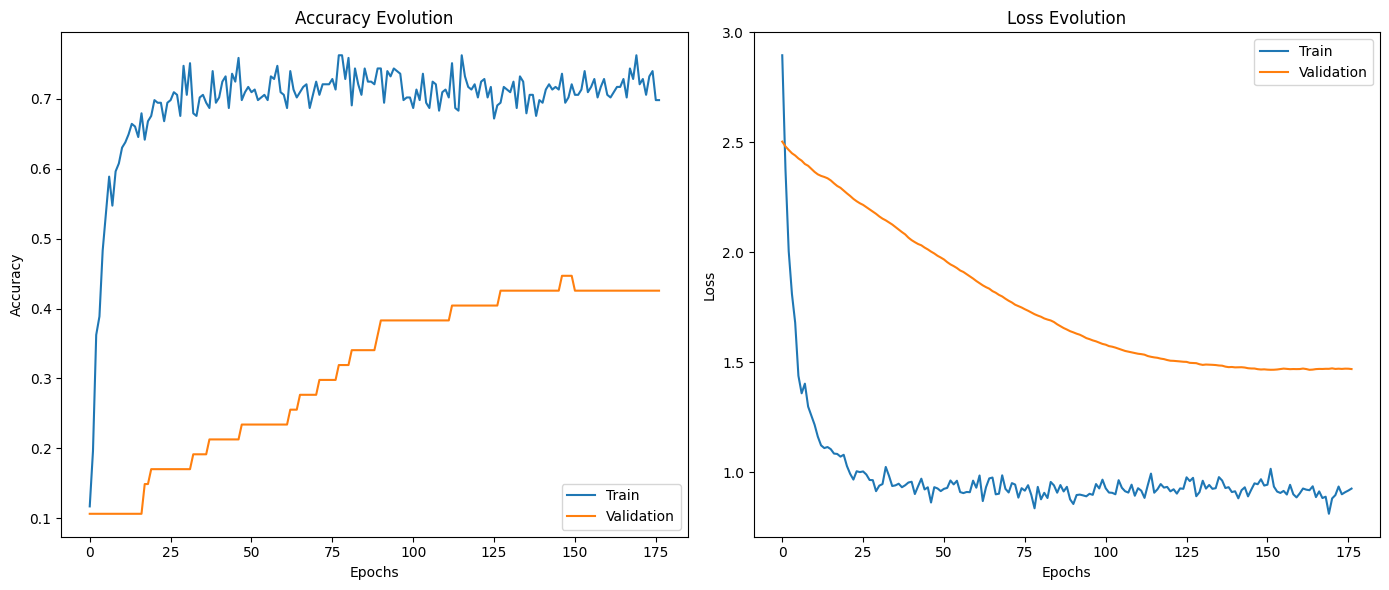

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

Final Predictions:
Input: ['sedan', 103.5, 164, 121, 4250, 25, 24565]
→ Predicted Make: bmw
--------------------------------------------------
Input: ['hatchback', 86.6, 92, 58, 4800, 54, 6479]
→ Predicted Make: toyota
--------------------------------------------------


In [ ]:
# Install required packages if needed
# !pip install imbalanced-learn tensorflow scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Nadam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# -----------------------------
# 1. LOAD AND CLEAN DATA
# -----------------------------
url = "http://users.jyu.fi/~olkhriye/ties4911/demos/demo1/Automobile_price_data_Raw_set.csv"
df = pd.read_csv(url)

# Clean and preprocess data
df.replace("?", np.nan, inplace=True)
numeric_columns = ['wheel-base', 'engine-size', 'horsepower',
                   'peak-rpm', 'highway-mpg', 'price']
required_columns = ['make', 'body-style'] + numeric_columns
df = df[required_columns]

# Convert to numeric and handle missing values
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute missing values
imputer = SimpleImputer(strategy='median')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
df.dropna(subset=['make', 'body-style'], inplace=True)

# Enhanced class filtering
min_class_count = 8
counts = df['make'].value_counts()
df = df[df['make'].isin(counts[counts >= min_class_count].index)]

# -----------------------------
# 2. FEATURE ENGINEERING
# -----------------------------
# Create meaningful features
df['power-to-weight'] = df['horsepower'] / (df['wheel-base'] + 1e-6)
df['engine-efficiency'] = df['highway-mpg'] / (df['engine-size'] + 1e-6)
df['price-per-eng-size'] = df['price'] / (df['engine-size'] + 1e-6)
df['log-price'] = np.log1p(df['price'])

# Encode categorical features
X = df[['body-style'] + numeric_columns + [
    'power-to-weight', 'engine-efficiency',
    'price-per-eng-size', 'log-price'
]]
y = df['make']

# -----------------------------
# 3. PREPROCESSING
# -----------------------------
# Encode features and target
ohe = OneHotEncoder(drop='first', sparse_output=False)
body_style_encoded = ohe.fit_transform(X[['body-style']])

# Combine features
numeric_features = X.drop(columns=['body-style']).values
X_processed = np.hstack([body_style_encoded, numeric_features])

# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# -----------------------------
# 4. DATA SPLITTING AND SCALING
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded,
    test_size=0.15,
    stratify=y_encoded,
    random_state=42
)

# Create preprocessing pipeline
preprocessor = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(k_neighbors=5, random_state=42))
])

X_res, y_res = preprocessor.fit_resample(X_train, y_train)

# -----------------------------
# 5. MODEL ARCHITECTURE
# -----------------------------
def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Dense(256, activation='swish', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='swish', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='swish'),
        BatchNormalization(),

        Dense(num_classes, activation='softmax')
    ])

    optimizer = Nadam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model((X_res.shape[1],), len(np.unique(y_encoded)))

# Fixed learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    return float(lr * np.exp(-0.1))  # Convert to Python float

# -----------------------------
# 6. CLASS WEIGHTS
# -----------------------------
classes = np.unique(y_res)
class_weights = compute_class_weight('balanced', classes=classes, y=y_res)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# -----------------------------
# 7. MODEL TRAINING
# -----------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True,
    min_delta=0.001
)

history = model.fit(
    X_res, y_res,
    validation_split=0.15,
    epochs=500,
    batch_size=64,
    verbose=0,
    callbacks=[early_stop, LearningRateScheduler(lr_scheduler)],
    class_weight=class_weight_dict
)

# -----------------------------
# 8. EVALUATION
# -----------------------------
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Accuracy: {test_acc*100:.2f}%")

# Plot training history
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 9. PREDICTIONS
# -----------------------------
new_samples = [
    ['sedan', 103.5, 164, 121, 4250, 25, 24565],
    ['hatchback', 86.6, 92, 58, 4800, 54, 6479]
]

def preprocess_new(samples):
    new_df = pd.DataFrame(samples, columns=['body-style'] + numeric_columns)

    # Calculate engineered features
    new_df['power-to-weight'] = new_df['horsepower'] / (new_df['wheel-base'] + 1e-6)
    new_df['engine-efficiency'] = new_df['highway-mpg'] / (new_df['engine-size'] + 1e-6)
    new_df['price-per-eng-size'] = new_df['price'] / (new_df['engine-size'] + 1e-6)
    new_df['log-price'] = np.log1p(new_df['price'])

    # Encode and scale
    body_style_encoded = ohe.transform(new_df[['body-style']])
    numeric_features = new_df.drop(columns=['body-style']).values
    processed = np.hstack([body_style_encoded, numeric_features])

    return preprocessor.named_steps['scaler'].transform(processed)

X_new = preprocess_new(new_samples)
predictions = model.predict(X_new)
predicted_classes = np.argmax(predictions, axis=1)
predicted_makes = label_encoder.inverse_transform(predicted_classes)

print("\nFinal Predictions:")
for sample, make in zip(new_samples, predicted_makes):
    print(f"Input: {sample}")
    print(f"→ Predicted Make: {make}")
    print("-" * 50)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initial shape of data: (205, 26)
Initial columns: Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')
Shape after removing classes with <2 samples: (151, 12)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 35.48%


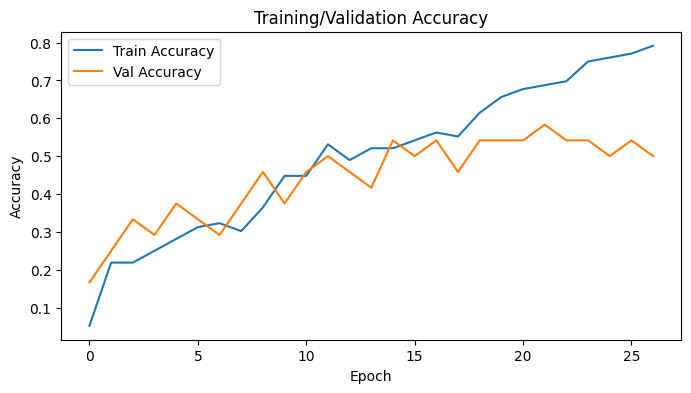

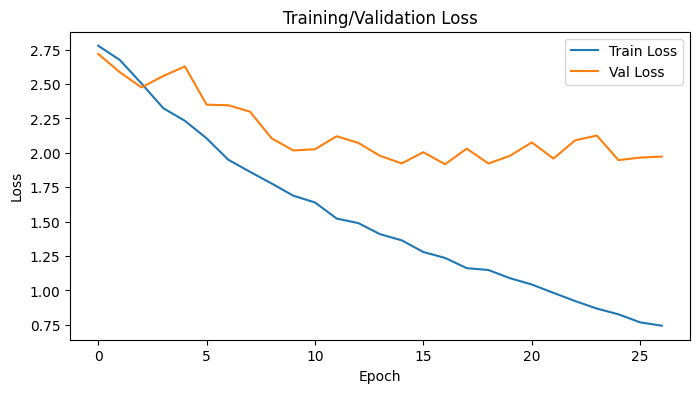

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

Predicted values for the two samples:
  Input: ['sedan', 'gas', 'std', 'fwd', 'front', 103.5, 164, 121, 4250, 25, 24565] -> Predicted Make: volvo
  Input: ['hatchback', 'gas', 'std', 'fwd', 'front', 86.6, 92, 58, 4800, 54, 6479] -> Predicted Make: honda

Model Accuracy on Test Set: 35.48%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For one-hot encoding & label encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# TensorFlow Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Automobile_price_data_Raw_set.csv'
df = pd.read_csv(file_path)

print("Initial shape of data:", df.shape)
print("Initial columns:", df.columns)

# 2. BASIC CLEANING & MISSING VALUES
df.replace([np.inf, -np.inf, "?"], np.nan, inplace=True)  # Convert '?' to NaN
df.dropna(inplace=True)  # Drop rows with any missing value

# 3. SELECT FEATURES AND TARGET

# We will use more features to improve classification performance.
# Specifically:
#   - Categorical: 'body-style', 'fuel-type', 'aspiration', 'drive-wheels', 'engine-location'
#   - Numeric: 'wheel-base', 'engine-size', 'horsepower', 'peak-rpm', 'highway-mpg', 'price'
#   - Target: 'make'
# Adjust if you find other columns more relevant.
categorical_cols = ['body-style', 'fuel-type', 'aspiration', 'drive-wheels', 'engine-location']
numeric_cols = ['wheel-base', 'engine-size', 'horsepower', 'peak-rpm', 'highway-mpg', 'price']
target_col = 'make'

# Filter down to only the columns we need
needed_cols = categorical_cols + numeric_cols + [target_col]
df = df[needed_cols].copy()

# 4. REMOVE RARE CLASSES (those with <2 samples) FOR STRATIFICATION
counts = df[target_col].value_counts()
rare_classes = counts[counts < 2].index
df = df[~df[target_col].isin(rare_classes)]
print("Shape after removing classes with <2 samples:", df.shape)

# 5. DEFINE FEATURES (X) AND LABELS (y)
X = df.drop(columns=[target_col])
y = df[target_col]

# 6. ENCODE CATEGORICAL FEATURES WITH ONE-HOT
ohe = OneHotEncoder(drop='first')  # drop='first' to avoid dummy trap
X_cat = ohe.fit_transform(X[categorical_cols]).toarray()

# CONVERT NUMERIC COLUMNS TO NUMPY ARRAY
X_num = X[numeric_cols].astype(float).values

# COMBINE ONE-HOT + NUMERIC
X_encoded = np.hstack((X_cat, X_num))

# 7. ENCODE THE TARGET (car make) WITH LABEL ENCODER
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 8. TRAIN/TEST SPLIT (use stratify to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# 9. SCALE NUMERIC FEATURES
# Find how many columns in X_cat
n_cat_features = X_cat.shape[1]
# All numeric features start from index n_cat_features onward
scaler = StandardScaler()
X_train[:, n_cat_features:] = scaler.fit_transform(X_train[:, n_cat_features:])
X_test[:, n_cat_features:] = scaler.transform(X_test[:, n_cat_features:])

# 10. BUILD THE MODEL
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    # Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

# 11. COMPILE THE MODEL with a custom learning rate
optimizer = Adam(learning_rate=0.01)  # Set LR to 0.01
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 12. DEFINE CALLBACKS
early_stop = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy'
    patience=10,         # # of epochs with no improvement before stopping
    restore_best_weights=True
)

# Optional: reduce LR on plateau
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,
#     patience=5,
#     min_lr=0.0001,
#     verbose=1
# )

# 13. TRAIN THE MODEL
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],  # add reduce_lr if you want
    verbose=0
)

# 14. EVALUATE THE MODEL
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# 15. PLOT TRAINING CURVES
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training/Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 16. PREDICT FOR NEW SAMPLES
# Let’s keep the original two sample inputs:
samples = [
    ['sedan', 'gas', 'std', 'fwd', 'front', 103.5, 164, 121, 4250, 25, 24565],
    ['hatchback', 'gas', 'std', 'fwd', 'front', 86.6, 92, 58, 4800, 54, 6479]
]

# Separate the cat vs numeric
samples_cat = [s[:5] for s in samples]    # the first 5 columns are categorical
samples_num = [s[5:] for s in samples]    # the rest are numeric

# One-hot encode the sample’s categorical part
samples_cat_ohe = ohe.transform(samples_cat).toarray()

# Convert numeric columns to float and scale
samples_num = np.array(samples_num, dtype=float)
samples_num_scaled = scaler.transform(samples_num)

# Combine
X_new = np.hstack((samples_cat_ohe, samples_num_scaled))

# Predict
pred_probs = model.predict(X_new)
predicted_classes = np.argmax(pred_probs, axis=1)
predicted_makes = label_encoder.inverse_transform(predicted_classes)

print("\nPredicted values for the two samples:")
for i, sample in enumerate(samples):
    print(f"  Input: {sample} -> Predicted Make: {predicted_makes[i]}")

print(f"\nModel Accuracy on Test Set: {test_accuracy*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


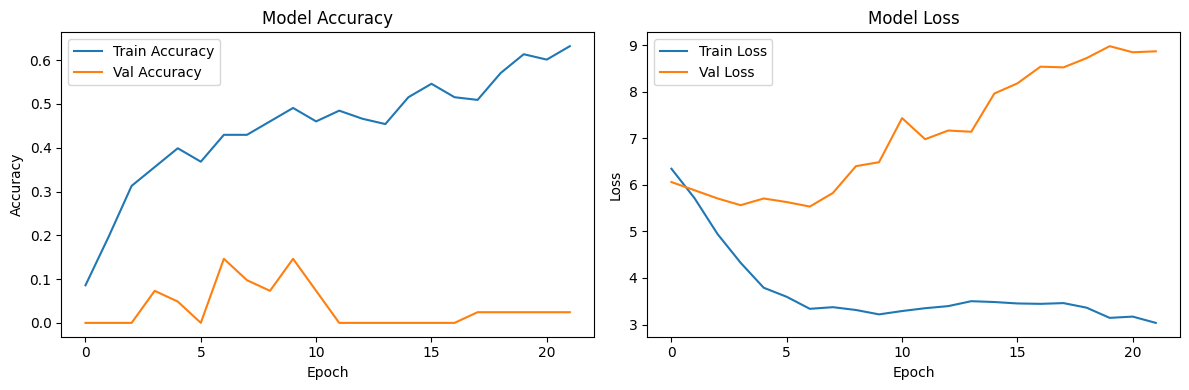

Cross-Validation Scores: [0.5609756112098694, 0.46341463923454285, 0.3658536672592163, 0.5853658318519592, 0.42500001192092896]
Mean CV Accuracy: 48.01%
Standard Deviation: 8.24%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step

Predicted Make: mercedes-benz
Prediction Probabilities: [0.03438666 0.04721367 0.08174981 0.03042794 0.05400392 0.06375886
 0.03606684 0.06911836 0.04829831 0.08646477 0.0360927  0.03815679
 0.04533121 0.03720014 0.04854439 0.02469282 0.03866372 0.04850411
 0.0462319  0.02105344 0.02563929 0.03840034]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing and ML libraries
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer

# TensorFlow Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

def load_and_preprocess_data(file_path):
    # Load data
    df = pd.read_csv(file_path)

    # Replace problematic values
    df.replace([np.inf, -np.inf, "?"], np.nan, inplace=True)

    # Impute missing values
    imputer = SimpleImputer(strategy='median')
    numeric_cols = ['wheel-base', 'engine-size', 'horsepower', 'peak-rpm', 'highway-mpg', 'price']
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

    # Select features
    categorical_cols = ['body-style', 'fuel-type', 'aspiration', 'drive-wheels', 'engine-location']
    target_col = 'make'

    # Remove rare classes
    counts = df[target_col].value_counts()
    rare_classes = counts[counts < 2].index
    df = df[~df[target_col].isin(rare_classes)]

    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    return X, y, categorical_cols, numeric_cols

def feature_engineering(X, categorical_cols, numeric_cols):
    # One-hot encoding for categorical features
    ohe = OneHotEncoder(drop='first')  # Removed sparse parameter
    X_cat = ohe.fit_transform(X[categorical_cols]).toarray()  # Explicitly convert to array

    # Numeric feature engineering
    X_num = X[numeric_cols].values

    # Polynomial features for numeric columns
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_num_poly = poly.fit_transform(X_num)

    # Combine features
    X_encoded = np.hstack((X_cat, X_num_poly))

    return X_encoded, ohe, poly

def create_model(input_shape, num_classes):
    model = Sequential([
        # Input layer with L2 regularization
        Dense(256, activation='relu', input_shape=(input_shape,),
              kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.1),

        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.1),

        Dense(32, activation='relu'),
        Dense(16, activation='relu'),

        Dense(num_classes, activation='softmax')
    ])

    # Advanced optimizer with adaptive learning rate
    optimizer = Adam(learning_rate=0.01,
                     beta_1=0.9,
                     beta_2=0.999,
                     epsilon=1e-7)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def train_and_evaluate_model(X, y):
    # Encode target
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Feature engineering
    X_encoded, ohe, poly = feature_engineering(X,
        ['body-style', 'fuel-type', 'aspiration', 'drive-wheels', 'engine-location'],
        ['wheel-base', 'engine-size', 'horsepower', 'peak-rpm', 'highway-mpg', 'price']
    )

    # Scale numeric features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)

    # Stratified K-Fold Cross Validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_index, val_index in kfold.split(X_scaled, y_encoded):
        X_train, X_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_val = y_encoded[train_index], y_encoded[val_index]

        # Create and train model
        model = create_model(X_scaled.shape[1], len(np.unique(y_encoded)))

        # Callbacks
        early_stop = EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=0.00001
        )

        # Train
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=200,
            batch_size=32,
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        # Evaluate
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        cv_scores.append(accuracy)

    # Final model training on full dataset
    final_model = create_model(X_scaled.shape[1], len(np.unique(y_encoded)))
    final_history = final_model.fit(
        X_scaled, y_encoded,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    # Plotting
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(final_history.history['accuracy'], label='Train Accuracy')
    plt.plot(final_history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(final_history.history['loss'], label='Train Loss')
    plt.plot(final_history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print cross-validation results
    print(f"Cross-Validation Scores: {cv_scores}")
    print(f"Mean CV Accuracy: {np.mean(cv_scores)*100:.2f}%")
    print(f"Standard Deviation: {np.std(cv_scores)*100:.2f}%")

    return final_model, scaler, ohe, poly, label_encoder

def main():
    # Update with your actual file path
    file_path = '/content/drive/MyDrive/Automobile_price_data_Raw_set.csv'

    # Load and preprocess data
    X, y, cat_cols, num_cols = load_and_preprocess_data(file_path)

    # Train and evaluate model
    model, scaler, ohe, poly, label_encoder = train_and_evaluate_model(X, y)

    # Sample prediction function
    def predict_car_make(sample_data):
        # Separate categorical and numeric parts
        cat_data = [sample_data[:5]]
        num_data = [sample_data[5:]]

        # Transform categorical data
        cat_transformed = ohe.transform(cat_data).toarray()

        # Transform numeric data
        num_transformed = poly.transform(num_data)

        # Combine and scale
        X_combined = np.hstack((cat_transformed, num_transformed))
        X_scaled = scaler.transform(X_combined)

        # Predict
        probs = model.predict(X_scaled)
        predicted_class = np.argmax(probs, axis=1)
        predicted_make = label_encoder.inverse_transform(predicted_class)

        return predicted_make[0], probs[0]

    # Example prediction
    sample = ['sedan', 'gas', 'std', 'fwd', 'front', 103.5, 164, 121, 4250, 25, 24565]
    predicted_make, probabilities = predict_car_make(sample)
    print(f"\nPredicted Make: {predicted_make}")
    print(f"Prediction Probabilities: {probabilities}")

if __name__ == "__main__":
    main()